# Week 6: Visual Odometry (VO)

In this week's assignment, you do not need. a GPU. You will use the pykitti module and KITTI odometry dataset.

You can download the odometry data from [here](https://drive.google.com/file/d/1PJOUnM3nEwDpqiRvfqUnkNPJZpM4PKYV/view?usp=sharing).

In [ ]:
!gdown --id 1PJOUnM3nEwDpqiRvfqUnkNPJZpM4PKYV

Downloading...
From: https://drive.google.com/uc?id=1PJOUnM3nEwDpqiRvfqUnkNPJZpM4PKYV
To: /content/KITTI_odometry.zip
317MB [00:01, 164MB/s]


In [ ]:
!unzip KITTI_odometry.zip

Archive:  KITTI_odometry.zip
replace KITTI_odometry/sequences/09/image_3/000025.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
!pip install pykitti

## Monocular VO with OpenCV on KITTI

For each consecutive frame pair in the sequence, you will compute the relative pose between the frames and visualize it. You will use:

* pykitti code similar to what you wrote in Week 3 to load the seqeunce with ground-truth info. (Check out the [demo code for odometry dataset](https://github.com/utiasSTARS/pykitti/blob/master/demos/demo_odometry.py))
* OpenCV functions to compute and visualize the features and the essential matrix.

Please follow these steps to complete the assignment:

1. You can use the ORB Feature to do the feature matching:
    `orb = cv2.ORB_create()` to create the ORB object
    and then `orb.detectAndCompute()` to find the keypoints and descriptors on both frames

2. You can use brute-force matcher to match ORB descriptors:
    `bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)`

3. After matching the descriptors, sort the matched keypoints.

4. Draw matches on the two images using the `cv2.drawMatches()` function.

5. Compute the essential matrix using the `cv2.findEssentialMat()` function. Note that you need the matching points and the instrinsics for this function. 

6. Extract the rotation and translation from the essential matrix using the `cv2.recoverPose()` function.

7. Multiply the estimated rotation and translation with the previous rotation and translation. Initialize rotation to identity and translation to zeros on the first frame.

8. Display the current image with the keypoints on it using the `cv2.drawKeypoints()` function.

9. Update the previous rotation and translation as the current rotation and translation.

10. Draw the estimated trajectory as blue and ground-truth trajectory as green. You can use the `cv2.circle()` function.


You can create a video of your visualization of images and poses for the provided sequence.

**Bonus**: Compute the absolute trajectory error between the estimated trajectory and the ground-truth trajectory. 

Some examples repositories that might be useful:
* https://bitbucket.org/castacks/visual_odometry_tutorial/src/master/visual-odometry/
* https://github.com/uoip/monoVO-python


\First ground truth pose:
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]

Second ground truth pose:
[[ 0.9999 -0.0119  0.0125  0.0705]
 [ 0.0119  0.9999 -0.0029 -0.0288]
 [-0.0125  0.003   0.9999  1.5009]
 [ 0.      0.      0.      1.    ]]


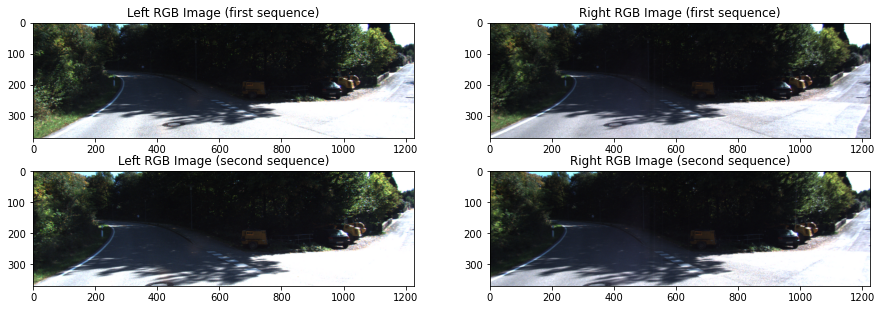

In [ ]:
"""Example of pykitti.odometry usage."""
import itertools
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

import pykitti

# Change this to the directory where you store KITTI data
basedir = '/content/KITTI_odometry/'

# Specify the dataset to load
sequence = '09'

# Load the data. Optionally, specify the frame range to load.
# dataset = pykitti.odometry(basedir, sequence)
dataset = pykitti.odometry(basedir, sequence, frames=range(0, 20, 5))

# dataset.calib:      Calibration data are accessible as a named tuple
# dataset.timestamps: Timestamps are parsed into a list of timedelta objects
# dataset.poses:      List of ground truth poses T_w_cam0
# dataset.camN:       Generator to load individual images from camera N
# dataset.gray:       Generator to load monochrome stereo pairs (cam0, cam1)
# dataset.rgb:        Generator to load RGB stereo pairs (cam2, cam3)

# Grab some data
first_pose = dataset.poses[0]
second_pose = dataset.poses[1]

first_rgb = dataset.get_rgb(0)
second_rgb = dataset.get_rgb(1)

# Display some of the data
np.set_printoptions(precision=4, suppress=True)

print('\First ground truth pose:\n' + str(first_pose))
print('\nSecond ground truth pose:\n' + str(second_pose))

f, ax = plt.subplots(2, 2, figsize=(15, 5))
ax[0, 0].imshow(first_rgb[0])
ax[0, 0].set_title('Left RGB Image (first sequence)')

ax[0, 1].imshow(first_rgb[1])
ax[0, 1].set_title('Right RGB Image (first sequence)')

ax[1, 0].imshow(second_rgb[0])
ax[1, 0].set_title('Left RGB Image (second sequence)')

ax[1, 1].imshow(second_rgb[1])
ax[1, 1].set_title('Right RGB Image (second sequence)')

plt.show()

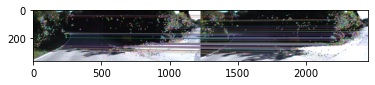

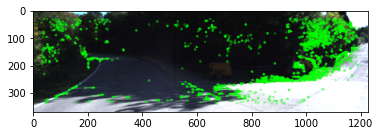

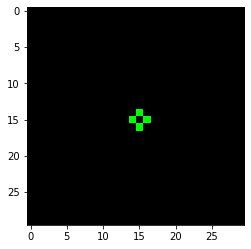

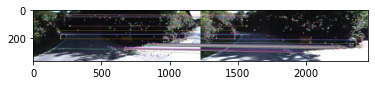

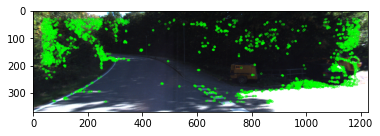

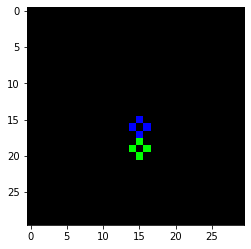

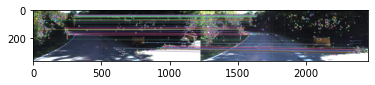

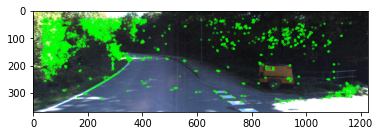

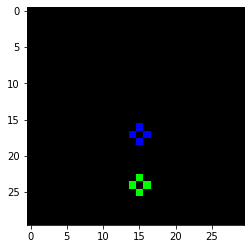

In [ ]:
import cv2

fx, fy, cx, cy = [718.8560, 718.8560, 607.1928, 185.2157]
num_frames = 4
len_trajMap = 30
outputs = []
for i in range(1, num_frames):
    trajMap = np.zeros((len_trajMap, len_trajMap, 3), dtype=np.uint8)

    is_right = 1
    curr_img = np.array(dataset.get_rgb(i)[is_right])

    if i == 0:
        curr_R = np.eye(3)
        curr_R_gt = np.eye(3)
        curr_t = np.array([0, 0, 0])
        curr_t_gt = np.array([0, 0, 0])
    else:
        # prev_imgName = img_data_dir + str(i - 1).zfill(6) + '.png'
        prev_img = np.array(dataset.get_rgb(i-1)[is_right])

        #====================== Use ORB Feature to do feature matching =====================#
        # create ORB features
        orb = cv2.ORB_create(nfeatures=6000)

        # find the keypoints and descriptors with ORB
        kp1, des1 = orb.detectAndCompute(prev_img, None)
        kp2, des2 = orb.detectAndCompute(curr_img, None)

        # use brute-force matcher
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

        # Match ORB descriptors
        matches = bf.match(des1, des2)

        # Sort the matched keypoints in the order of matching distance
        # so the best matches came to the front
        matches = sorted(matches, key=lambda x: x.distance)

        img_matching = cv2.drawMatches(prev_img, kp1, curr_img, kp2, matches[0:100], None)
        plt.imshow(img_matching)
        plt.show()

        pts1 = np.float32([kp1[m.queryIdx].pt for m in matches])
        pts2 = np.float32([kp2[m.trainIdx].pt for m in matches])

        # compute essential matrix
        E, mask = cv2.findEssentialMat(pts1, pts2, focal=fx, pp=(cx, cy), method=cv2.RANSAC, prob=0.999, threshold=1)
        pts1 = pts1[mask.ravel() == 1]
        pts2 = pts2[mask.ravel() == 1]
        _, R, t, mask = cv2.recoverPose(E, pts1, pts2, focal=fx, pp=(cx, cy))

        # get camera motion
        R = R.transpose()
        t = -np.matmul(R, t)

        # get ground truth camera motion
        R_gt = dataset.poses[i][:3, :3]
        t_gt = dataset.poses[i][:3, 3:4]

        if i == 1:
            curr_R = R
            curr_t = t
            curr_R_gt = R
            curr_t_gt = t
        else:
            curr_R = np.matmul(prev_R, R)
            curr_t = np.matmul(prev_R, t) + prev_t
            curr_R_gt = np.matmul(prev_R_gt, R_gt)
            curr_t_gt = np.matmul(prev_R_gt, t_gt) + prev_t_gt

        # draw the current image with keypoints
        curr_img_kp = cv2.drawKeypoints(curr_img, kp2, None, color=(0, 255, 0), flags=0)
        plt.imshow(curr_img_kp)
        plt.show()

    prev_R = curr_R
    prev_t = curr_t
    prev_R_gt = curr_R_gt
    prev_t_gt = curr_t_gt

    # draw estimated trajectory (blue) and gt trajectory (green)
    offset_draw = (int(len_trajMap/2))
    cv2.circle(trajMap, (int(curr_t[0])+offset_draw, int(curr_t[2])+offset_draw), 1, (0,0,255), 1)
    cv2.circle(trajMap, (int(curr_t_gt[0])+offset_draw, int(curr_t_gt[2])+offset_draw), 1, (0,255,0), 1)
    plt.imshow(trajMap)
    outputs.append(trajMap)
    plt.show()
out.release()